In [1]:
using AutoRisk
using BayesNets
using DataFrames
using Discretizers
using Distributions
using HDF5
using Interact
using JLD
using PGFPlots
using TikzPictures

In [2]:
# load the data
# input_filepath = "../../data/datasets/april/risk_mc_32.h5"
input_filepath = "../../data/datasets/risk_bn.h5"
raw_features = h5open(input_filepath, "r") do file
    read(file, "risk/features")
end;
raw_targets = h5open(input_filepath, "r") do file
    read(file, "risk/targets")
end;

In [3]:
debug_size = min(200000, size(raw_features, 3))
timestep = size(raw_features, 2)
features = view(raw_features, :, timestep, 1:debug_size);
targets = view(raw_targets, :, 1:debug_size);

In [4]:
attributes = h5readattr(input_filepath, "risk")
feature_names = attributes["feature_names"];

In [5]:
# sanitize the data
# remove features deterministically associated with a collision
valid_target_inds = find(abs(sum(targets[1:3,:], 1) .- 1.) .> .2)

# threshold velocities
vel_ind = find(feature_names .== "velocity")[1]
valid_vel_inds = find(5. .< features[vel_ind, :] .< 25.)

# threshold relative velocity between leading and trailing vehicles
fore_m_vel_ind = find(feature_names .== "fore_m_vel")[1]
valid_rel_vel_inds = find(abs(features[vel_ind, :] .- features[fore_m_vel_ind, :]) .< 5.)

# threshold distances
dist_ind = find(feature_names .== "fore_m_dist")[1]
valid_dist_inds = find(2. .< features[dist_ind, :] .< 40.)

valid_inds = intersect(valid_target_inds, valid_vel_inds, valid_rel_vel_inds, valid_dist_inds)
features = features[:, valid_inds];
println(size(valid_inds))
println(size(features))

(162583,)
(236,162583)


In [6]:
bn_feature_names = ["velocity", "fore_m_vel", "fore_m_dist"]
inds = [find(feature_names .== name)[1] for name in bn_feature_names]
base_data = features[inds,:];

In [7]:
# add aggressivenss by inferring it from politeness
politeness_index = find(feature_names .== "lane_politeness")[1]
politness_values = features[politeness_index,:];
aggressiveness_values = infer_correlated_aggressiveness(politness_values);
aggressiveness_values = reshape(aggressiveness_values, (1, length(aggressiveness_values)))
push!(bn_feature_names, "aggressiveness")
data = cat(1, base_data, aggressiveness_values)

4×162583 Array{Float64,2}:
 13.0183    15.3019    12.9768    …  15.2762      20.0176    18.0339  
 12.3791    16.9082    13.3773       15.7922      18.1901    18.6007  
 15.2083    19.8863    15.5526       17.4386      37.4781    23.3097  
  0.236033   0.346517   0.312707      0.00528515   0.417069   0.463311

In [8]:
# get is_attentive separately since it's discrete
is_attentive_index = find(feature_names .== "is_attentive")[1]
num_samples = size(data, 2)
is_attentive_values = ones(Int, num_samples)
for sidx in 1:num_samples
    is_attentive_values[sidx] = features[is_attentive_index,sidx] > .5 ? 2 : 1
end

In [9]:
# discretize the data
# features
num_variables, num_samples = size(data)
num_bins = [15,15,4,3]
disc_data = zeros(Int, num_variables, num_samples)
cutpoints = []
discs = []
algo = DiscretizeUniformWidth # DiscretizeUniformCount
for vidx in 1:num_variables
    disc = LinearDiscretizer(binedges(algo(num_bins[vidx]), data[vidx,:]))
    push!(cutpoints, disc.binedges)
    for sidx in 1:num_samples
        c = 0
        val = data[vidx, sidx]
        for (c, (lo, hi)) in enumerate(zip(disc.binedges, disc.binedges[2:end]))
            if lo <= val < hi
                break
            end
        end
    disc_data[vidx, sidx] = c
    end
end
println(cutpoints)

Any[[5.01288,6.04393,7.67498,9.00603,10.3371,11.6681,12.9992,14.3302,15.6613,16.9923,18.3234,19.6544,20.9855,22.3165,23.6476,24.9786],[1.69127,3.35264,5.01401,6.67538,8.33675,9.99812,11.6595,13.3209,14.9822,16.6436,18.305,19.9663,21.6277,23.2891,24.9505,26.6118],[4.65067,13.4877,22.3247,31.1617,39.9987],[7.82976e-6,0.333338,0.666669,0.999999]]


In [10]:
# convert data to dataframe
training_data = DataFrame(
        velocity = disc_data[1,:], 
        forevelocity = disc_data[2,:],
        foredistance = disc_data[3,:], 
        aggressiveness = disc_data[4,:],
        isattentive = is_attentive_values
);

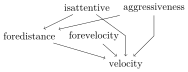

In [11]:
bn = fit(DiscreteBayesNet, training_data, (
    :isattentive=>:foredistance, 
    :isattentive=>:velocity,
    :aggressiveness=>:foredistance, 
    :aggressiveness=>:velocity,
    :foredistance=>:velocity,
    :forevelocity=>:velocity
    )
)

In [12]:
# report CPDs
for k in [:isattentive, :aggressiveness, :foredistance, :forevelocity, :velocity]
    println(table(bn, k))
end

2×2 DataFrames.DataFrame
│ Row │ isattentive │ p        │
├─────┼─────────────┼──────────┤
│ 1   │ 1           │ 0.049895 │
│ 2   │ 2           │ 0.957105 │
3×2 DataFrames.DataFrame
│ Row │ aggressiveness │ p        │
├─────┼────────────────┼──────────┤
│ 1   │ 1              │ 0.298967 │
│ 2   │ 2              │ 0.354637 │
│ 3   │ 3              │ 0.346395 │
24×4 DataFrames.DataFrame
│ Row │ aggressiveness │ isattentive │ foredistance │ p           │
├─────┼────────────────┼─────────────┼──────────────┼─────────────┤
│ 1   │ 1              │ 1           │ 1            │ 0.0782987   │
│ 2   │ 2              │ 1           │ 1            │ 0.0083612   │
│ 3   │ 3              │ 1           │ 1            │ 0.0         │
│ 4   │ 1              │ 2           │ 1            │ 0.0083612   │
│ 5   │ 2              │ 2           │ 1            │ 0.0642486   │
│ 6   │ 3              │ 2           │ 1            │ 0.000910696 │
│ 7   │ 1              │ 1           │ 2            │ 0.426776    │


In [13]:
# map the feature symbols to binedges
var_edges = Dict{Symbol,Vector{Float64}}()
var_edges[:velocity] = cutpoints[1]
var_edges[:forevelocity] = cutpoints[2]
var_edges[:foredistance] = cutpoints[3]
var_edges[:aggressiveness] = cutpoints[4]
var_edges

Dict{Symbol,Array{Float64,1}} with 4 entries:
  :velocity       => [5.01288,6.34393,7.67498,9.00603,10.3371,11.6681,12.9992,1…
  :foredistance   => [4.65067,13.4877,22.3247,31.1617,39.9987]
  :forevelocity   => [1.69127,3.35264,5.01401,6.67538,8.33675,9.99812,11.6595,1…
  :aggressiveness => [7.82976e-6,0.333338,0.666669,0.999999]

In [14]:
JLD.save("../../data/bayesnets/base_test.jld", "bn", bn, "var_edges", var_edges)

In [15]:
# proposal bn
# inattentive
is_attentive_values[1:100000] = 1
# close proximity
disc_data[3,1:50000] = 1 
disc_data[3,50000:100000] = 2
# aggressive
disc_data[4,1:80000] = 3
training_data = DataFrame(
        velocity = disc_data[1,:], 
        forevelocity = disc_data[2,:],
        foredistance = disc_data[3,:], 
        aggressiveness = disc_data[4,:],
        isattentive = is_attentive_values
);

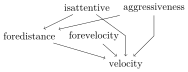

In [16]:
bn = fit(DiscreteBayesNet, training_data, (
    :isattentive=>:foredistance, 
    :isattentive=>:velocity,
    :aggressiveness=>:foredistance, 
    :aggressiveness=>:velocity,
    :foredistance=>:velocity,
    :forevelocity=>:velocity
    )
)

In [17]:
# report CPDs
for k in [:isattentive, :aggressiveness, :foredistance, :forevelocity, :velocity]
    println(table(bn, k))
end

2×2 DataFrames.DataFrame
│ Row │ isattentive │ p        │
├─────┼─────────────┼──────────┤
│ 1   │ 1           │ 0.632077 │
│ 2   │ 2           │ 0.367923 │
3×2 DataFrames.DataFrame
│ Row │ aggressiveness │ p        │
├─────┼────────────────┼──────────┤
│ 1   │ 1              │ 0.151787 │
│ 2   │ 2              │ 0.179219 │
│ 3   │ 3              │ 0.668994 │
24×4 DataFrames.DataFrame
│ Row │ aggressiveness │ isattentive │ foredistance │ p           │
├─────┼────────────────┼─────────────┼──────────────┼─────────────┤
│ 1   │ 1              │ 1           │ 1            │ 0.00818713  │
│ 2   │ 2              │ 1           │ 1            │ 0.000502197 │
│ 3   │ 3              │ 1           │ 1            │ 0.568429    │
│ 4   │ 1              │ 2           │ 1            │ 0.000502197 │
│ 5   │ 2              │ 2           │ 1            │ 0.06346     │
│ 6   │ 3              │ 2           │ 1            │ 0.00062479  │
│ 7   │ 1              │ 1           │ 2            │ 0.927485    │


In [18]:
JLD.save("../../data/bayesnets/prop_test.jld", "bn", bn, "var_edges", var_edges)